In [42]:
import scipy.stats as stats
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from tqdm import trange
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from tensorflow import keras
import scipy.stats

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, show_overall_progress=True, update_per_second=1)
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.0002)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

best_model = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10000,
    verbose=2, 
    restore_best_weights=True
)

In [2]:
sigma_prior = 10.
sigma_likelihood = 0.02

def f(x_input, eps1, eps2, eps3):
    return x_input + 0.3 * np.sin(2 * np.pi * x_input + eps1) + 0.3 * np.sin(4 * np.pi * x_input + eps2) + eps3

n_train = 512
n_test = n_train
np.random.seed(42)

X_train = np.linspace(0, 0.5, n_train).reshape(n_train, 1)


X_test = np.linspace(-0.5, 1.5, n_test).reshape(n_test, 1)

eps1 = np.random.normal(0, sigma_likelihood, (n_train, 1))
eps2 = np.random.normal(0, sigma_likelihood, (n_train, 1))
eps3 = np.random.normal(0, sigma_likelihood, (n_train, 1))

eps1t = np.random.normal(0, sigma_likelihood, (n_test, 1))
eps2t = np.random.normal(0, sigma_likelihood, (n_test, 1))
eps3t = np.random.normal(0, sigma_likelihood, (n_test, 1))

y_train = f(X_train, eps1, eps3, eps3)
y_test = f(X_test, eps1t, eps2t, eps3t)

x_dim = X_train.shape[1]
y_dim = y_train.shape[1]

sigma_prior = np.float32(sigma_prior)
sigma_likelihood = np.float32(sigma_likelihood)

In [3]:
def log_prior(x):
    dist_gaussian = tfd.Normal(np.float32(0.), sigma_prior)
    pdf = -tf.reduce_sum(dist_gaussian.log_prob(tf.cast(x, tf.float32)))# - tf.reduce_sum(dist_laplace.log_prob(tf.cast(x, tf.float32)))
    return tf.cast(pdf, tf.float32)

def log_likelihood(y_true, y_pred):
    dist = tfd.Normal(0, sigma_likelihood)
    pdf = -n_train*tf.reduce_mean(dist.log_prob(y_true - y_pred))
    return tf.cast(pdf, tf.float32)


input_layer = tf.keras.layers.Input((1), name='input')

dense_layer_1 = tf.keras.layers.Dense(4, activation='swish', name='dense_1', 
                                      kernel_regularizer=log_prior,
#                                       bias_regularizer=log_prior
                                     )(input_layer)
dense_layer_2 = tf.keras.layers.Dense(8, activation='swish', name='dense_2', 
                                      kernel_regularizer=log_prior,
#                                       bias_regularizer=log_prior
                                     )(dense_layer_1)
dense_layer_3 = tf.keras.layers.Dense(8, activation='swish', name='dense_3', 
                                      kernel_regularizer=log_prior,
#                                       bias_regularizer=log_prior
                                     )(dense_layer_2)
dense_layer_4 = tf.keras.layers.Dense(4, activation='swish', name='dense_4', 
                                      kernel_regularizer=log_prior,
#                                       bias_regularizer=log_prior
                                     )(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(1, activation='linear', name='dense_5', 
                                      kernel_regularizer=log_prior,
#                                       bias_regularizer=log_prior
                                     )(dense_layer_4)

model = tf.keras.Model(inputs=[input_layer], 
                              outputs=dense_layer_5, 
                              name='model')

model.compile(optimizer=tf.keras.optimizers.Nadam(1e-2),
              loss=log_likelihood,
              metrics=['mse'])


In [4]:
model.summary()
for layer in model.layers[1:]:
    print(layer.get_weights()[0].size, layer.get_weights()[1].size)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8         
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params:

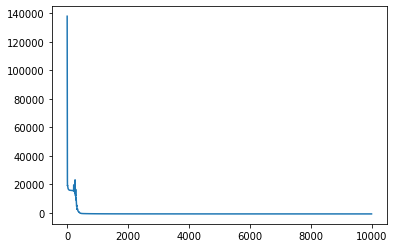

In [5]:
history = model.fit(X_train, y_train, epochs=10000, verbose=0, 
                    callbacks=[tqdm_callback, callback], batch_size=n_train)
plt.plot(history.history['loss'])
plt.show()
y_pred = model.predict(X_test)

Text(0, 0.5, 'y')

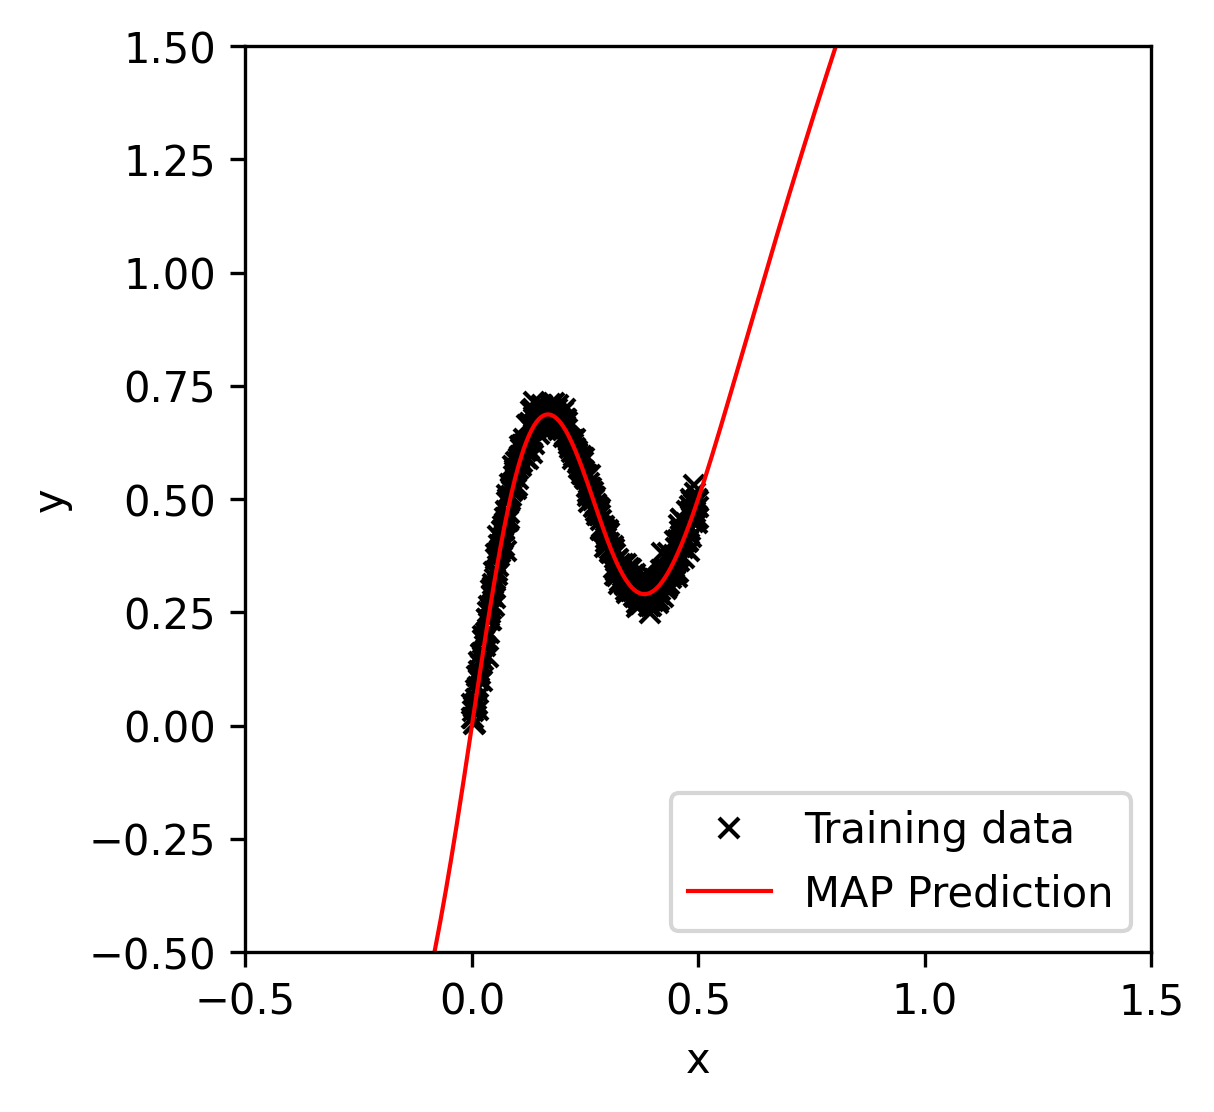

In [6]:
plt.figure(dpi=300)

plt.plot(X_train.flatten(), y_train.flatten(), 'kx', ms=5, label='Training data')
# plt.plot(X_test.flatten(), y_test.flatten(), '.', ms=5, label='Test data')
plt.plot(X_test.flatten(), y_pred.flatten(), 'r', lw=1, label='MAP Prediction')

plt.axis('square')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

plt.legend(loc="lower right")
plt.xlabel('x')
plt.ylabel('y')

In [7]:
def make_model_full():

    class KLDivergence:
        def __init__(self, q_dist, p_dist):
            self.q_dist = q_dist
            self.p_dist = p_dist
        def call(self):
            return tfp.distributions.kl_divergence(self.q_dist, self.p_dist)

    def likelihood_loss(y_true, y_pred):
        dist = tfd.Normal(0, sigma_likelihood)
        pdf = -n_train*tf.reduce_mean(dist.log_prob(y_true - y_pred))
        return tf.cast(pdf, tf.float32)

    posterior_fn = tfp.layers.default_mean_field_normal_fn(
              loc_initializer=tf.random_normal_initializer(
                  mean=0, stddev=0.01),
              untransformed_scale_initializer=tf.random_normal_initializer(
                  mean=np.log(np.exp(0.2) - 1), stddev=0.0))

    def prior_fn(dtype, shape, name, trainable, add_variable_fn):
        dist = tfp.distributions.Normal(loc=0*tf.ones(shape, dtype),
                                 scale=sigma_prior*tf.ones(shape, dtype))
        multivar_dist = tfp.distributions.Independent(dist, reinterpreted_batch_ndims=tf.size(dist.batch_shape_tensor()))
        return multivar_dist
    
    def tensor_fn(d):
        return d.sample()

    flipout_params = dict(activation="swish",
                  kernel_prior_fn=prior_fn,
#                   bias_prior_fn=prior_fn,
                  kernel_posterior_fn=posterior_fn,
#                   bias_posterior_fn=posterior_fn,
                  kernel_divergence_fn=None,
#                   bias_divergence_fn=None,
                  kernel_posterior_tensor_fn=tensor_fn,
#                   bias_posterior_tensor_fn=tensor_fn,
                         )

    flipout_params_final = dict(activation="linear",
                                kernel_prior_fn=prior_fn,
#                                 bias_prior_fn=prior_fn,
                                kernel_posterior_fn=posterior_fn,
#                                 bias_posterior_fn=posterior_fn,
                                kernel_divergence_fn=None,
#                                 bias_divergence_fn=None,
                                kernel_posterior_tensor_fn=tensor_fn,
#                                 bias_posterior_tensor_fn=tensor_fn,
                               )

    params_final = dict(activation="linear", kernel_regularizer=log_prior)

    params = dict(activation="swish", kernel_regularizer=log_prior)


    input_layer = keras.layers.Input(shape=(1), name="input_layer")

    dense_layer_1 = tfp.layers.DenseReparameterization(4, name='dense_1', **flipout_params)(input_layer)
    dense_layer_2 = tfp.layers.DenseReparameterization(8, name='dense_2', **flipout_params)(dense_layer_1)
    dense_layer_3 = tfp.layers.DenseReparameterization(8, name='dense_3', **flipout_params)(dense_layer_2)
    dense_layer_4 = tfp.layers.DenseReparameterization(4, name='dense_4', **flipout_params)(dense_layer_3)
    dense_layer_5 = tfp.layers.DenseReparameterization(1, name='dense_5', **flipout_params_final)(dense_layer_4)

    model_full = keras.models.Model(inputs=input_layer, outputs=dense_layer_5,
                               name = 'model_full')

    for layer in model_full.layers:
        if type(layer) == tfp.python.layers.dense_variational.DenseReparameterization:
            layer.add_loss(KLDivergence(layer.kernel_posterior, layer.kernel_prior).call)
#             layer.add_loss(KLDivergence(layer.bias_posterior, layer.bias_prior).call)

    model_full.compile(optimizer=keras.optimizers.Nadam(learning_rate=3e-3),
                  loss=likelihood_loss,
                  metrics=['mse'],
                  )

    return model_full

In [8]:
model_full = make_model_full()
model_full.summary()
for layer_map, layer_full in zip(model.layers, model_full.layers):
    if len(layer_map.trainable_variables) is not 0:
        layer_full_weights = layer_full.get_weights()
        layer_map_weights = layer_map.get_weights()
        layer_full_weights[0] = layer_map_weights[0]
        layer_full_weights[2] = layer_map_weights[1]
        layer_full.set_weights(layer_full_weights)

Model: "model_full"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 dense_1 (DenseReparameteriz  (None, 4)                12        
 ation)                                                          
                                                                 
 dense_2 (DenseReparameteriz  (None, 8)                72        
 ation)                                                          
                                                                 
 dense_3 (DenseReparameteriz  (None, 8)                136       
 ation)                                                          
                                                                 
 dense_4 (DenseReparameteriz  (None, 4)                68        
 ation)                                                 

/Users/hauthj/miniconda3/envs/test-env/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:106: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/Users/hauthj/miniconda3/envs/test-env/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:116: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


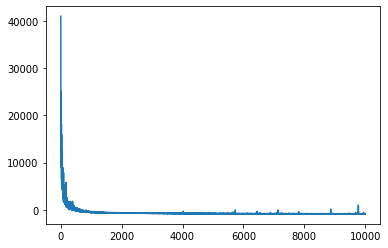

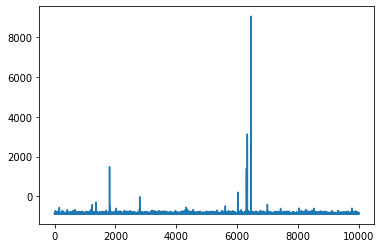

In [9]:
history_full = model_full.fit(X_train, y_train, epochs=10000, verbose=0, 
                    callbacks=[tqdm_callback, callback, best_model], batch_size=n_train//8)
plt.plot(history_full.history['loss'])
plt.show()
history_full = model_full.fit(X_train, y_train, epochs=10000, verbose=0, 
                    callbacks=[tqdm_callback, callback, best_model], batch_size=n_train)
plt.plot(history_full.history['loss'])
plt.show()

In [10]:
y_pred_full_list = []
for _ in trange(1000):
    y_pred_full_list.append(model_full.predict(X_train, batch_size=n_train))
y_pred_full = np.concatenate(y_pred_full_list, axis=1)

100%|██████████| 1000/1000 [00:39<00:00, 25.44it/s]


In [11]:
def make_model_partial(partial_layer):
    

    class KLDivergence:
        def __init__(self, q_dist, p_dist):
            self.q_dist = q_dist
            self.p_dist = p_dist
        def call(self):
            return tfp.distributions.kl_divergence(self.q_dist, self.p_dist)

    def likelihood_loss(y_true, y_pred):
        dist = tfd.Normal(0, sigma_likelihood)
        pdf = -n_train*tf.reduce_mean(dist.log_prob(y_true - y_pred))
        return tf.cast(pdf, tf.float32)

    posterior_fn = tfp.layers.default_mean_field_normal_fn(
              loc_initializer=tf.random_normal_initializer(
                  mean=0, stddev=0.01),
              untransformed_scale_initializer=tf.random_normal_initializer(
                  mean=np.log(np.exp(0.2) - 1), stddev=0.01))

    def prior_fn(dtype, shape, name, trainable, add_variable_fn):
        dist = tfp.distributions.Normal(loc=0*tf.ones(shape, dtype),
                                 scale=sigma_prior*tf.ones(shape, dtype))
        multivar_dist = tfp.distributions.Independent(dist, reinterpreted_batch_ndims=tf.size(dist.batch_shape_tensor()))
        return multivar_dist
    
    def tensor_fn(d):
        return d.sample()

    flipout_params = dict(activation="swish",
                  kernel_prior_fn=prior_fn,
#                   bias_prior_fn=prior_fn,
                  kernel_posterior_fn=posterior_fn,
#                   bias_posterior_fn=posterior_fn,
                  kernel_divergence_fn=None,
#                   bias_divergence_fn=None,
                  kernel_posterior_tensor_fn=tensor_fn,
#                   bias_posterior_tensor_fn=tensor_fn,
                         )

    flipout_params_final = dict(activation="linear",
                                kernel_prior_fn=prior_fn,
#                                 bias_prior_fn=prior_fn,
                                kernel_posterior_fn=posterior_fn,
#                                 bias_posterior_fn=posterior_fn,
                                kernel_divergence_fn=None,
#                                 bias_divergence_fn=None,
                                kernel_posterior_tensor_fn=tensor_fn,
#                                 bias_posterior_tensor_fn=tensor_fn,
                               )

    params_final = dict(activation="linear", kernel_regularizer=log_prior)

    params = dict(activation="swish", kernel_regularizer=log_prior)


    input_layer = keras.layers.Input(shape=(1), name="input_layer")

    dense_layer_1 = tf.keras.layers.Dense(4, name='dense_1', **params)(input_layer)
    if partial_layer==1:
        dense_layer_1 = tfp.layers.DenseReparameterization(4, name='dense_1', **flipout_params)(input_layer)
    
    dense_layer_2 = tf.keras.layers.Dense(8, name='dense_2', **params)(dense_layer_1)
    if partial_layer==2:
        dense_layer_2 = tfp.layers.DenseReparameterization(8, name='dense_2', **flipout_params)(dense_layer_1)   
    
    dense_layer_3 = tf.keras.layers.Dense(8, name='dense_3', **params)(dense_layer_2)
    if partial_layer==3:
        dense_layer_3 = tfp.layers.DenseReparameterization(8, name='dense_3', **flipout_params)(dense_layer_2)
        
    dense_layer_4 = tf.keras.layers.Dense(4, name='dense_4', **params)(dense_layer_3)
    if partial_layer==4:
        dense_layer_4 = tfp.layers.DenseReparameterization(4, name='dense_4', **flipout_params)(dense_layer_3)
    
    dense_layer_5 = tf.keras.layers.Dense(1, name='dense_5', **params_final)(dense_layer_4)
    if partial_layer==5:
        dense_layer_5 = tfp.layers.DenseReparameterization(1, name='dense_5', **flipout_params_final)(dense_layer_4)

    model_partial = keras.models.Model(inputs=input_layer, outputs=dense_layer_5,
                               name = 'model_partial_'+str(partial_layer))

    for layer in model_partial.layers:
        if type(layer) == tfp.python.layers.dense_variational.DenseReparameterization:
            layer.add_loss(KLDivergence(layer.kernel_posterior, layer.kernel_prior).call)
#             layer.add_loss(KLDivergence(layer.bias_posterior, layer.bias_prior).call)

    model_partial.compile(optimizer=keras.optimizers.Nadam(learning_rate=3e-3),
                  loss=likelihood_loss,
                  metrics=['mse'],
                  )

    return model_partial


Model: "model_partial_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 dense_1 (DenseReparameteriz  (None, 4)                12        
 ation)                                                          
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                   

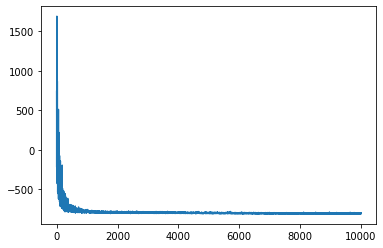

100%|██████████| 1000/1000 [00:35<00:00, 28.53it/s]


In [12]:
model_partial_1 = make_model_partial(1)
model_partial_1.summary()
for layer_map, layer_partial in zip(model.layers, model_partial_1.layers):
    if len(layer_map.trainable_variables) is not 0:
        layer_partial_weights = layer_partial.get_weights()
        layer_map_weights = layer_map.get_weights()
        layer_partial_weights[0] = layer_map_weights[0]
        if len(layer_partial.trainable_variables) > 2:
            layer_partial_weights[2] = layer_map_weights[1]
        else:
            layer_partial_weights[1] = layer_map_weights[1]
        layer_partial.set_weights(layer_partial_weights)
        
history_partial_1 = model_partial_1.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train//8,
                    callbacks=[tqdm_callback, callback])
plt.plot(history_partial_1.history['loss'])
plt.show()
# history_partial_1 = model_partial_1.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train,
#                     callbacks=[tqdm_callback, callback])
# plt.semilogy(history_partial_1.history['loss'])
# plt.show()

y_pred_partial_list_1 = []
for _ in trange(1000):
    y_pred_partial_list_1.append(model_partial_1.predict(X_train, batch_size=n_test))
y_pred_partial_1 = np.concatenate(y_pred_partial_list_1, axis=1)

Model: "model_partial_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8         
                                                                 
 dense_2 (DenseReparameteriz  (None, 8)                72        
 ation)                                                          
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                   

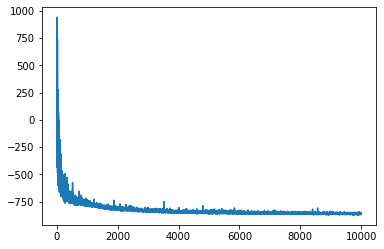

100%|██████████| 1000/1000 [00:34<00:00, 29.37it/s]


In [13]:
model_partial_2 = make_model_partial(2)
model_partial_2.summary()
for layer_map, layer_full in zip(model.layers, model_partial_2.layers):
    if len(layer_map.trainable_variables) is not 0:
        layer_full_weights = layer_full.get_weights()
        layer_map_weights = layer_map.get_weights()
        layer_full_weights[0] = layer_map_weights[0]
        if len(layer_full.trainable_variables) > 2:
            layer_full_weights[2] = layer_map_weights[1]
        else:
            layer_full_weights[1] = layer_map_weights[1]
        layer_full.set_weights(layer_full_weights)
        
history_partial_2 = model_partial_2.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train//8,
                    callbacks=[tqdm_callback, callback])
plt.plot(history_partial_2.history['loss'])
plt.show()
# history_partial_2 = model_partial_2.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train,
#                     callbacks=[tqdm_callback, callback])
# plt.semilogy(history_partial_2.history['loss'])
# plt.show()

y_pred_partial_list_2 = []
for _ in trange(1000):
    y_pred_partial_list_2.append(model_partial_2.predict(X_train, batch_size=n_test))
y_pred_partial_2 = np.concatenate(y_pred_partial_list_2, axis=1)

Model: "model_partial_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8         
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (DenseReparameteriz  (None, 8)                136       
 ation)                                                          
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                   

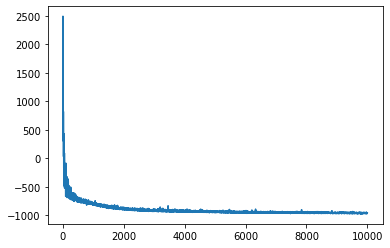

100%|██████████| 1000/1000 [00:35<00:00, 28.45it/s]


In [14]:
model_partial_3 = make_model_partial(3)
model_partial_3.summary()
for layer_map, layer_full in zip(model.layers, model_partial_3.layers):
    if len(layer_map.trainable_variables) is not 0:
        layer_full_weights = layer_full.get_weights()
        layer_map_weights = layer_map.get_weights()
        layer_full_weights[0] = layer_map_weights[0]
        if len(layer_full.trainable_variables) > 2:
            layer_full_weights[2] = layer_map_weights[1]
        else:
            layer_full_weights[1] = layer_map_weights[1]
        layer_full.set_weights(layer_full_weights)
history_partial_3 = model_partial_3.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train//8,
                    callbacks=[tqdm_callback, callback])
plt.plot(history_partial_3.history['loss'])
plt.show()
# history_partial_3 = model_partial_3.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train,
#                     callbacks=[tqdm_callback, callback])
# plt.semilogy(history_partial_3.history['loss'])
# plt.show()
y_pred_partial_list_3 = []
for _ in trange(1000):
    y_pred_partial_list_3.append(model_partial_3.predict(X_train, batch_size=n_test))
y_pred_partial_3 = np.concatenate(y_pred_partial_list_3, axis=1)

Model: "model_partial_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8         
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (DenseReparameteriz  (None, 4)                68        
 ation)                                                          
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                   

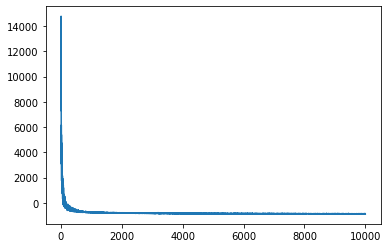

In [15]:
model_partial_4 = make_model_partial(4)
model_partial_4.summary()
for layer_map, layer_full in zip(model.layers, model_partial_4.layers):
    if len(layer_map.trainable_variables) is not 0:
        layer_full_weights = layer_full.get_weights()
        layer_map_weights = layer_map.get_weights()
        layer_full_weights[0] = layer_map_weights[0]
        if len(layer_full.trainable_variables) > 2:
            layer_full_weights[2] = layer_map_weights[1]
        else:
            layer_full_weights[1] = layer_map_weights[1]
        layer_full.set_weights(layer_full_weights)
history_partial_4 = model_partial_4.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train//8,
                    callbacks=[tqdm_callback, callback])
plt.plot(history_partial_4.history['loss'])
plt.show()
# history_partial_4 = model_partial_4.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train,
#                     callbacks=[tqdm_callback, callback])
# plt.semilogy(history_partial_4.history['loss'])
# plt.show()
y_pred_partial_list_4 = []
for _ in range(1000):
    y_pred_partial_list_4.append(model_partial_4.predict(X_train, batch_size=n_test))
y_pred_partial_4 = np.concatenate(y_pred_partial_list_4, axis=1)

Model: "model_partial_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8         
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (DenseReparameteriz  (None, 1)                9         
 ation)                                                          
                                                   

/Users/hauthj/miniconda3/envs/test-env/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:106: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/Users/hauthj/miniconda3/envs/test-env/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:116: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


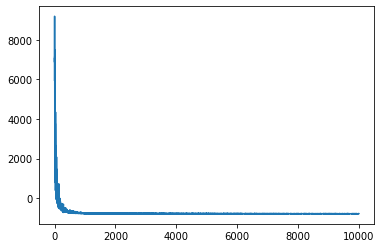

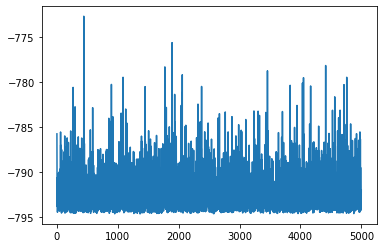

100%|██████████| 1000/1000 [00:37<00:00, 26.41it/s]


In [37]:
model_partial_5 = make_model_partial(5)
model_partial_5.summary()
for layer_map, layer_full in zip(model.layers, model_partial_5.layers):
    if len(layer_map.trainable_variables) is not 0:
        layer_full_weights = layer_full.get_weights()
        layer_map_weights = layer_map.get_weights()
        layer_full_weights[0] = layer_map_weights[0]
        if len(layer_full.trainable_variables) > 2:
            layer_full_weights[2] = layer_map_weights[1]
        else:
            layer_full_weights[1] = layer_map_weights[1]
        layer_full.set_weights(layer_full_weights)
history_partial_5 = model_partial_5.fit(X_train, y_train, epochs=10000, verbose=0, batch_size=n_train//8,
                    callbacks=[tqdm_callback, callback])
plt.plot(history_partial_5.history['loss'])
plt.show()
history_partial_5 = model_partial_5.fit(X_train, y_train, epochs=5000, verbose=0, batch_size=n_train,
                    callbacks=[tqdm_callback, callback, best_model])
plt.plot(history_partial_5.history['loss'])
plt.show()
y_pred_partial_list_5 = []
for _ in trange(1000):
    y_pred_partial_list_5.append(model_partial_5.predict(X_train, batch_size=n_test))
y_pred_partial_5 = np.concatenate(y_pred_partial_list_5, axis=1)

In [17]:
n_stds = 3

In [18]:
# y_pred_full_list = []
# for _ in range(100):
#     y_pred_full_list.append(model_full.predict(X_train, batch_size=n_test))
# y_pred_full = np.concatenate(y_pred_full_list, axis=1)

# y_pred_partial_list_1 = []
# for _ in range(100):
#     y_pred_partial_list_1.append(model_partial_1.predict(X_train, batch_size=n_test))
# y_pred_partial_1 = np.concatenate(y_pred_partial_list_1, axis=1)

# y_pred_partial_list_2 = []
# for _ in range(100):
#     y_pred_partial_list_2.append(model_partial_2.predict(X_train, batch_size=n_test))
# y_pred_partial_2 = np.concatenate(y_pred_partial_list_2, axis=1)

# y_pred_partial_list_3 = []
# for _ in range(100):
#     y_pred_partial_list_3.append(model_partial_3.predict(X_train, batch_size=n_test))
# y_pred_partial_3 = np.concatenate(y_pred_partial_list_3, axis=1)

# y_pred_partial_list_4 = []
# for _ in range(100):
#     y_pred_partial_list_4.append(model_partial_4.predict(X_train, batch_size=n_test))
# y_pred_partial_4 = np.concatenate(y_pred_partial_list_4, axis=1)

# y_pred_partial_list_5 = []
# for _ in range(100):
#     y_pred_partial_list_5.append(model_partial_5.predict(X_train, batch_size=n_test))
# y_pred_partial_5 = np.concatenate(y_pred_partial_list_5, axis=1)

In [38]:
full_dist = tfd.MultivariateNormalDiag(y_pred_full.mean(1), scale_diag=y_pred_full.std(1) + sigma_likelihood)
partial_dist_1 = tfd.MultivariateNormalDiag(y_pred_partial_1.mean(1), scale_diag=y_pred_partial_1.std(1) + sigma_likelihood)
partial_dist_2 = tfd.MultivariateNormalDiag(y_pred_partial_2.mean(1), scale_diag=y_pred_partial_2.std(1) + sigma_likelihood)
partial_dist_3 = tfd.MultivariateNormalDiag(y_pred_partial_3.mean(1), scale_diag=y_pred_partial_3.std(1) + sigma_likelihood)
partial_dist_4 = tfd.MultivariateNormalDiag(y_pred_partial_4.mean(1), scale_diag=y_pred_partial_4.std(1) + sigma_likelihood)
partial_dist_5 = tfd.MultivariateNormalDiag(y_pred_partial_5.mean(1), scale_diag=y_pred_partial_5.std(1) + sigma_likelihood)

kl_partial_1 = tfd.kl_divergence(full_dist, partial_dist_1).numpy()
kl_partial_2 = tfd.kl_divergence(full_dist, partial_dist_2).numpy()
kl_partial_3 = tfd.kl_divergence(full_dist, partial_dist_3).numpy()
kl_partial_4 = tfd.kl_divergence(full_dist, partial_dist_4).numpy()
kl_partial_5 = tfd.kl_divergence(full_dist, partial_dist_5).numpy()
kl_full = tfd.kl_divergence(full_dist, full_dist).numpy()

entropy_partial_1 = partial_dist_1.entropy().numpy()
entropy_partial_2 = partial_dist_2.entropy().numpy()
entropy_partial_3 = partial_dist_3.entropy().numpy()
entropy_partial_4 = partial_dist_4.entropy().numpy()
entropy_partial_5 = partial_dist_5.entropy().numpy()
entropy_full = full_dist.entropy().numpy()

print('kl_partial_1', '%0.1f' % kl_partial_1)
print('kl_partial_2', '%0.1f' % kl_partial_2)
print('kl_partial_3', '%0.1f' % kl_partial_3)
print('kl_partial_4', '%0.1f' % kl_partial_4)
print('kl_partial_5', '%0.1f' % kl_partial_5)
print('kl_full', '%0.1f' % kl_full)
print()
print('entropy_partial_1', '%0.1f' % entropy_partial_1)
print('entropy_partial_2', '%0.1f' % entropy_partial_2)
print('entropy_partial_3', '%0.1f' % entropy_partial_3)
print('entropy_partial_4', '%0.1f' % entropy_partial_4)
print('entropy_partial_5', '%0.1f' % entropy_partial_5)
print('entropy_full', '%0.1f' % entropy_full)

kl_partial_1 31.3
kl_partial_2 15.2
kl_partial_3 14.1
kl_partial_4 10.1
kl_partial_5 23.7
kl_full 0.0

entropy_partial_1 -1249.2
entropy_partial_2 -1220.3
entropy_partial_3 -1211.2
entropy_partial_4 -1204.1
entropy_partial_5 -1234.6
entropy_full -1145.6


pBNN will ALWAYS deliver lower uncertainty than the full BNN 
    (due to fewer degrees of freedom)<br>
    Joint Entropy >= Conditional Entropy<br>

Prove that pBNN with greatest entropy will be closest pBNN to true BNN (in terms of entropy)
    (EZPZ)<br>
    **LOOKUP** Principle of maximum entropy<br>
    **LOOKUP** Mutual Information<br>
    
    
    P = BNN
    Q = pBNN
    
    h(P)
    h(Q)
    
    h(Q) <= h(P)
    
    KL = h(P,Q) - h(P)
    ∆h = h(P) - h(Q)
    
    
Choice of layer based on max entropy (should be correlated to min KL)\<br>

Heuristic needed to avoid running all partial layers <br>
Want to avoid running all layers if--<br>
   1) a layer is too large (for our computational resources, e.g. memory, HDD, GPU, time, etc.)<br>
   2) **running all individual layers is more expensive than just
       doing the full BNN**<br>
   3) Cheap option preferred<br>
       
       
Heuristic correlates KL or Entropy with easy to calculate metric (e.g. sensitivity)<br>

Don't need to prove any kind of 'optimality' of our particular metric,
whether sensitivity, $\frac{d\theta} {d\mathcal L}$, other...

**TODO**:<br>
calculate heuristic metrics (sensitivity)<br>
<!-- Calculate metrics for just training region<br> -->

Outline
1) Proof<br>
2) Toy<br>
3) Tumor<br>
4) Impact: why is UQ important for radiology<br>
.
.
.
10) Profit!<br>

Entropy - uncertainty of a distribution
KL - measure of discrepency between two distributions

Maximum entropy is w full Bayesian model
Partial Bayesian models will ALWAYS have less entropy

Use local sensitivity for here on out

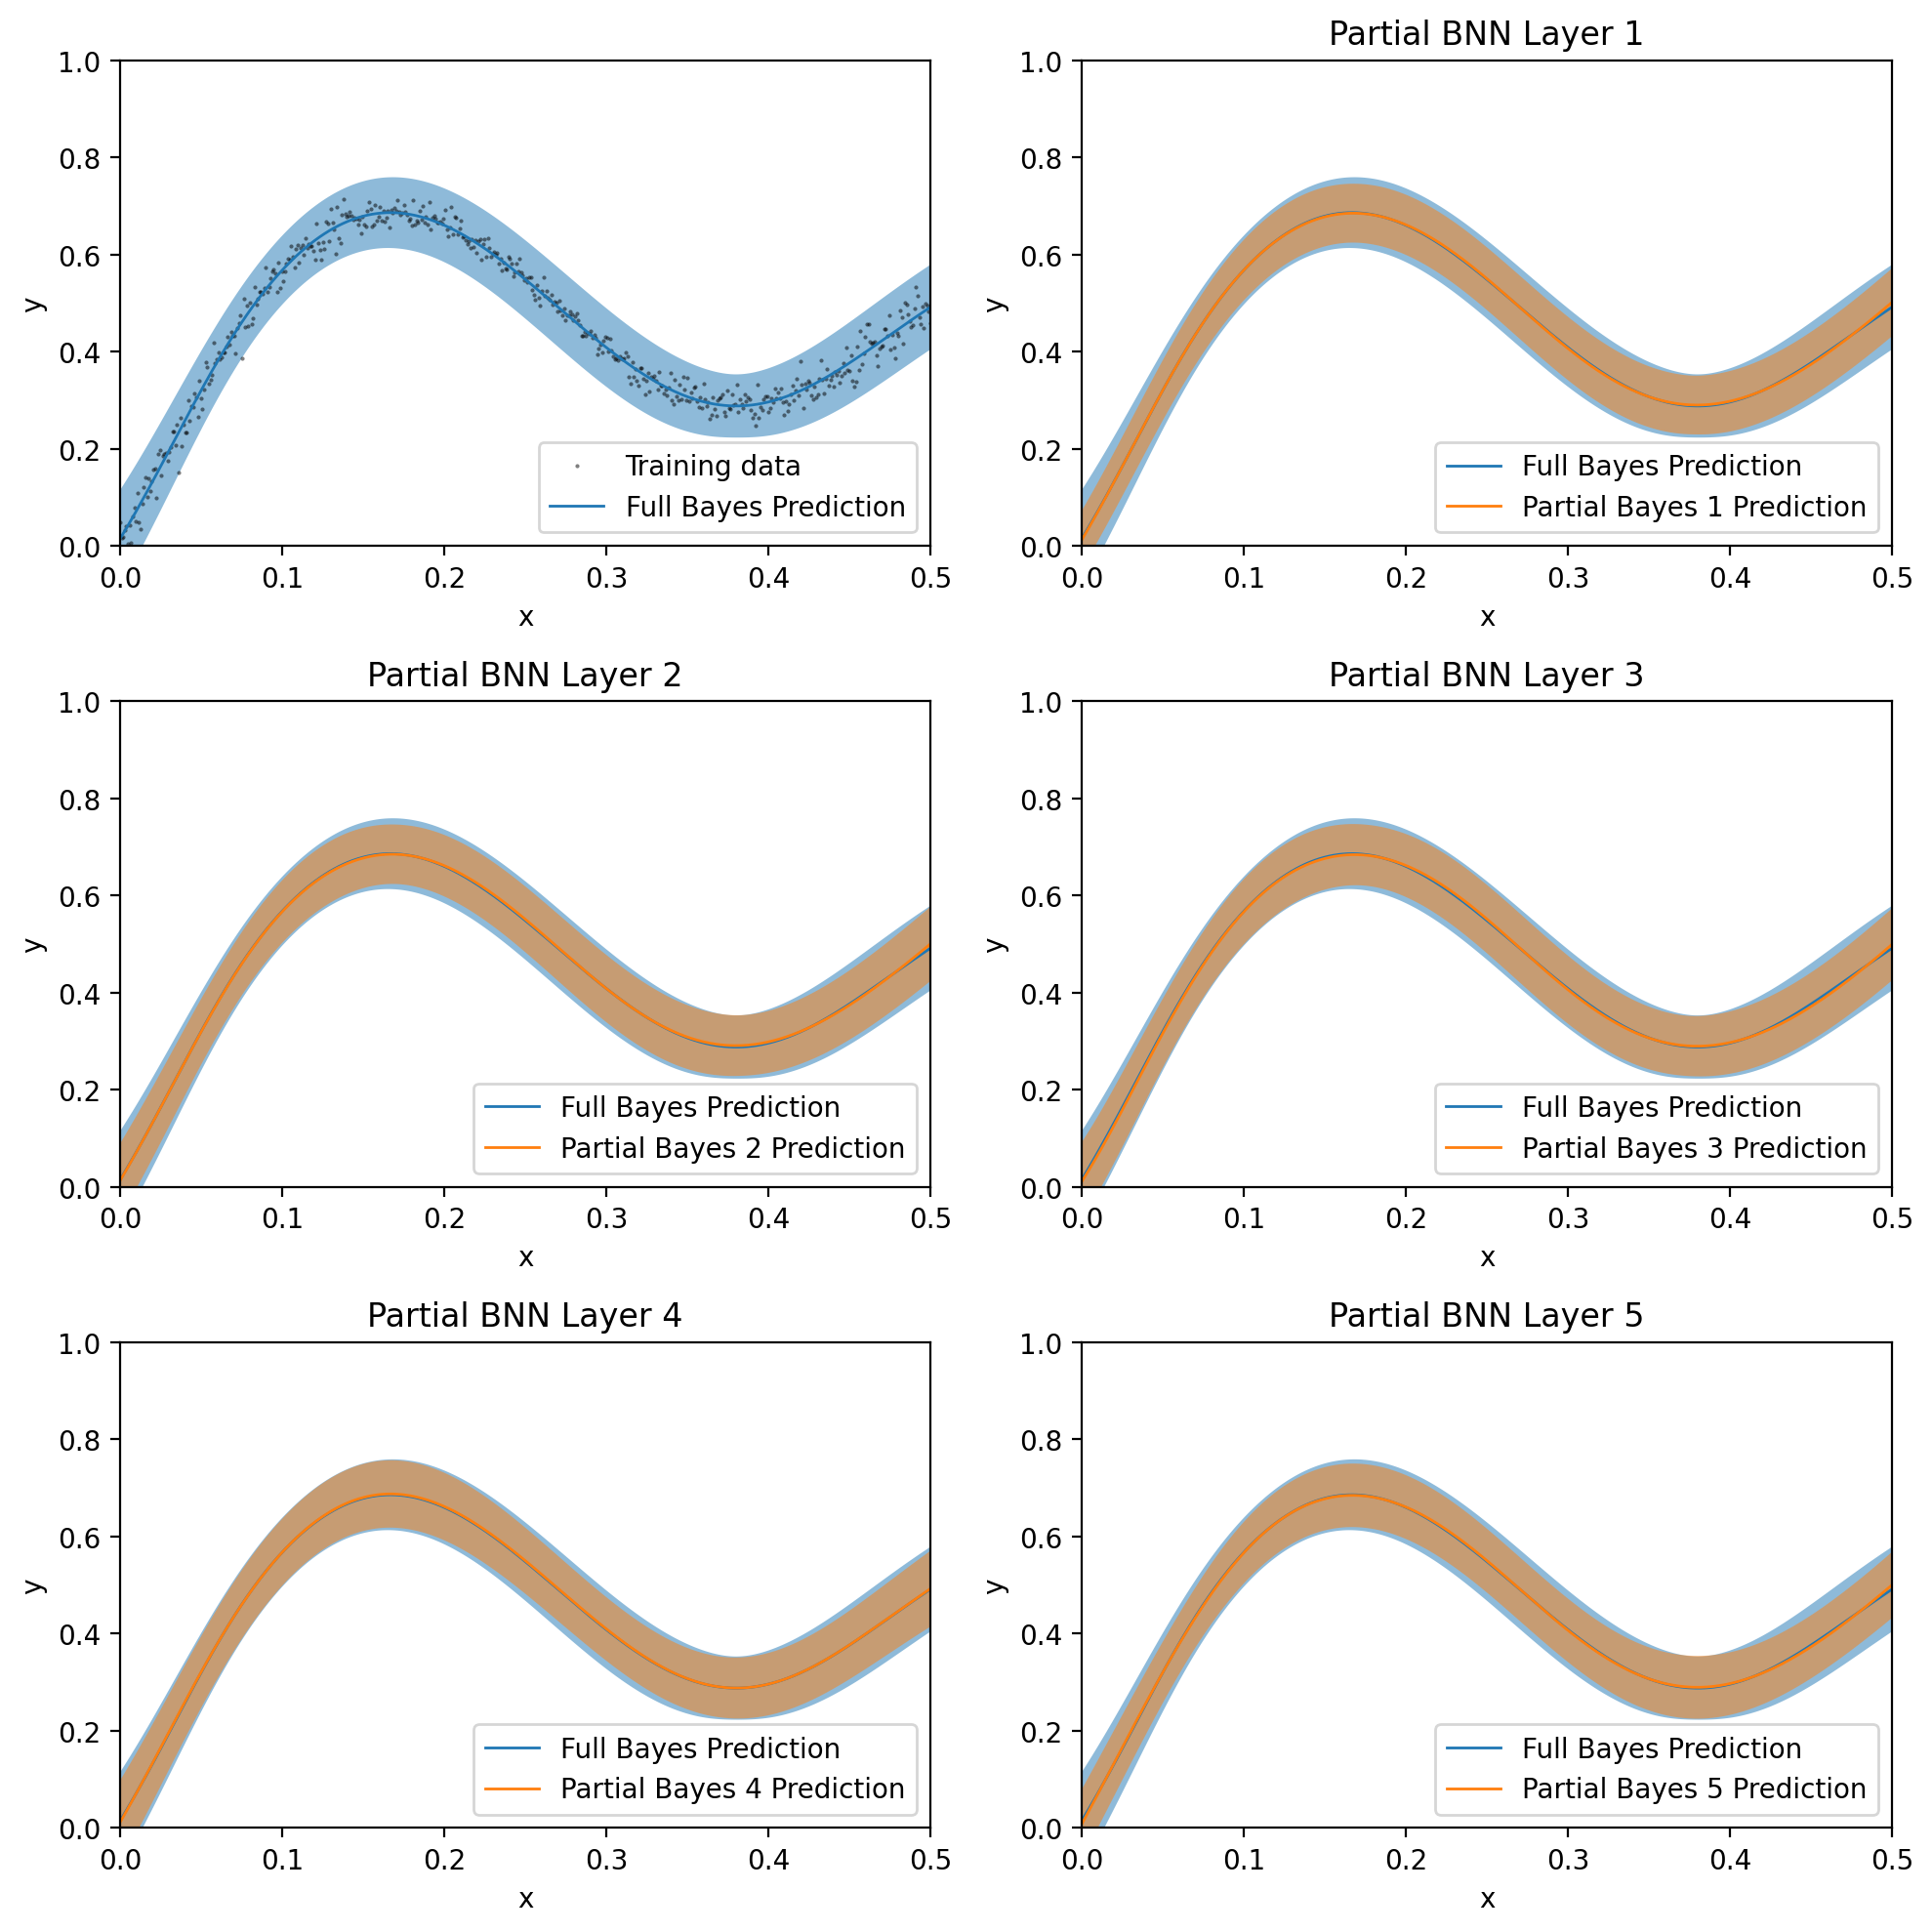

In [106]:
plt.figure(figsize=(10, 10), dpi=200)
plt.subplot(3, 2, 1)
plt.plot(X_train.flatten(), y_train.flatten(), 'k.', ms=1, label='Training data', alpha=0.5)
# plt.plot(X_test.flatten(), y_test.flatten(), '.', ms=5, label='Test data')
# plt.plot(X_test.flatten(), y_pred.flatten(), 'k', lw=1, label='MAP Prediction')
plt.fill_between(X_train.flatten(), 
                 y_pred_full.mean(1).flatten() + n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 y_pred_full.mean(1).flatten() - n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_full.mean(1).flatten(), lw=1, label='Full Bayes Prediction')
plt.legend(loc="lower right")
# plt.axis('square')
plt.xlim(0,0.5);
plt.ylim(0,1);
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(3, 2, 2)
plt.title('Partial BNN Layer 1')
# \n KL = ' + str(kl_partial_1) + '\nKL*param = ' + '%0.1f' % (kl_partial_1*8))
plt.fill_between(X_train.flatten(), 
                 y_pred_full.mean(1).flatten() + n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 y_pred_full.mean(1).flatten() - n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_full.mean(1).flatten(), lw=1, label='Full Bayes Prediction')
plt.fill_between(X_train.flatten(), 
                 y_pred_partial_1.mean(1).flatten() + n_stds*(y_pred_partial_1.std(1).flatten() + sigma_likelihood), 
                 y_pred_partial_1.mean(1).flatten() - n_stds*(y_pred_partial_1.std(1).flatten() + sigma_likelihood),
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_partial_1.mean(1).flatten(), lw=1, label='Partial Bayes 1 Prediction')

plt.legend(loc="lower right")
# plt.axis('square')
plt.xlim(0,0.5);
plt.ylim(0,1);
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(3, 2, 3)
plt.title('Partial BNN Layer 2')
# \n KL = ' + str(kl_partial_2) + '\nKL*param = ' + '%0.1f' % (kl_partial_2*40))
plt.fill_between(X_train.flatten(), 
                 y_pred_full.mean(1).flatten() + n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 y_pred_full.mean(1).flatten() - n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_full.mean(1).flatten(), lw=1, label='Full Bayes Prediction')
plt.fill_between(X_train.flatten(), 
                 y_pred_partial_2.mean(1).flatten() + n_stds*(y_pred_partial_2.std(1).flatten() + sigma_likelihood), 
                 y_pred_partial_2.mean(1).flatten() - n_stds*(y_pred_partial_2.std(1).flatten() + sigma_likelihood), 
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_partial_2.mean(1).flatten(), lw=1, label='Partial Bayes 2 Prediction')
plt.legend(loc="lower right")
# plt.axis('square')
plt.xlim(0,0.5);
plt.ylim(0,1);
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(3, 2, 4)
plt.title('Partial BNN Layer 3')
#           \n KL = ' + str(kl_partial_3) + '\nKL*param = ' + '%0.1f' % (kl_partial_3*72))
plt.fill_between(X_train.flatten(), 
                 y_pred_full.mean(1).flatten() + n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 y_pred_full.mean(1).flatten() - n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_full.mean(1).flatten(), lw=1, label='Full Bayes Prediction')
plt.fill_between(X_train.flatten(), 
                 y_pred_partial_3.mean(1).flatten() + n_stds*(y_pred_partial_3.std(1).flatten() + sigma_likelihood), 
                 y_pred_partial_3.mean(1).flatten() - n_stds*(y_pred_partial_3.std(1).flatten() + sigma_likelihood),
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_partial_3.mean(1).flatten(), lw=1, label='Partial Bayes 3 Prediction')
plt.legend(loc="lower right")
# plt.axis('square')
plt.xlim(0,0.5);
plt.ylim(0,1);
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(3, 2, 5)
plt.title('Partial BNN Layer 4')
#           \n KL = ' + str(kl_partial_4) + '\nKL*param = ' + '%0.1f' % (kl_partial_4*36))
plt.fill_between(X_train.flatten(), 
                 y_pred_full.mean(1).flatten() + n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 y_pred_full.mean(1).flatten() - n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_full.mean(1).flatten(), lw=1, label='Full Bayes Prediction')
plt.fill_between(X_train.flatten(), 
                 y_pred_partial_4.mean(1).flatten() + n_stds*(y_pred_partial_4.std(1).flatten() + sigma_likelihood), 
                 y_pred_partial_4.mean(1).flatten() - n_stds*(y_pred_partial_4.std(1).flatten() + sigma_likelihood),
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_partial_4.mean(1).flatten(), lw=1, label='Partial Bayes 4 Prediction')
plt.legend(loc="lower right")
# plt.axis('square')
plt.xlim(0,0.5);
plt.ylim(0,1);
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(3, 2, 6)
plt.title('Partial BNN Layer 5')
#           \n KL = ' + str(kl_partial_5) + '\nKL*param = ' + '%0.1f' % (kl_partial_5*5))
plt.fill_between(X_train.flatten(), 
                 y_pred_full.mean(1).flatten() + n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 y_pred_full.mean(1).flatten() - n_stds*(y_pred_full.std(1).flatten() + sigma_likelihood), 
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_full.mean(1).flatten(), lw=1, label='Full Bayes Prediction')
plt.fill_between(X_train.flatten(), 
                 y_pred_partial_5.mean(1).flatten() + n_stds*(y_pred_partial_5.std(1).flatten() + sigma_likelihood), 
                 y_pred_partial_5.mean(1).flatten() - n_stds*(y_pred_partial_5.std(1).flatten() + sigma_likelihood),
                 lw=1, alpha=0.5)
plt.plot(X_train.flatten(), y_pred_partial_5.mean(1).flatten(), lw=1, label='Partial Bayes 5 Prediction')
plt.legend(loc="lower right")
# plt.axis('square')
plt.xlim(0,0.5);
plt.ylim(0,1);
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [110]:
var = model.trainable_variables

with tf.GradientTape() as tape:
    tape.watch(var)
    y_pred = model(X_train)
grad = tape.gradient(y_pred, var)

In [122]:
grad_list = []
for var_, grad_ in zip(var, grad):
    if 'kernel' in var_.name:
        grad_list.append(abs(grad_.numpy().sum()))
grad_list.append(sum(grad_list))

In [123]:
grad_list

[20.559784, 35.367355, 48.349224, 276.1135, 81.18208, 461.5719413757324]

In [102]:
noisy_layer_pred_list = []
y_pred_true_list = []
full_noisy_pred_list = []
model_true_weights = model.get_weights()

n_samples = 300

for layer in model.layers[1:]:
    noisy_pred_list = []
    true_weights = layer.get_weights()
    for _ in trange(n_samples):
        noisy_weights = []
        for weight in true_weights:
            noisy_weights.append(1.*weight)
        for individual_weight in noisy_weights[:1]:
            individual_weight += np.random.normal(0, 1., individual_weight.shape)
        layer.set_weights(noisy_weights)
        y_pred_noisy = model.predict(X_train, batch_size=n_train, verbose=0)
        noisy_pred_list.append(y_pred_noisy)
        y_pred_true_list.append(true_weights[0])
    noisy_layer_pred_list.append(noisy_pred_list)
    layer.set_weights(true_weights)
    y_pred = model.predict(X_train, batch_size=n_train, verbose=0)

for _ in trange(n_samples):
    for layer in model.layers[1:]:
        true_weights = layer.get_weights()
        noisy_weights = []
        for weight in true_weights:
            noisy_weights.append(1.*weight)
        for individual_weight in noisy_weights[:1]:
            individual_weight += np.random.normal(0, 1., individual_weight.shape)
        layer.set_weights(noisy_weights)
    y_pred_noisy = model.predict(X_train, batch_size=n_train, verbose=0)
    full_noisy_pred_list.append(y_pred_noisy)
#     noisy_layer_pred_list.append(noisy_pred_list)
    model.set_weights(model_true_weights)
#     y_pred = model.predict(X_train, batch_size=n_train, verbose=0)
noisy_layer_pred_list.append(full_noisy_pred_list)


100%|██████████| 300/300 [00:12<00:00, 24.99it/s]


In [131]:
sensitivity = np.log(np.array(grad_list))
sensitivity = np.array(noisy_layer_pred_list).std(1).mean(1).flatten()
# sensitivity_param = sensitivity / np.array([8, 40, 72, 36, 5, 161])
# kl_param_list = np.array([8*kl_partial_1, 40*kl_partial_2, 72*kl_partial_3, 36*kl_partial_4, 5*kl_partial_5, 161*kl_full])
kl_list = np.array([kl_partial_1, kl_partial_2, kl_partial_3, kl_partial_4, kl_partial_5, kl_full])
# entropy_param_list = np.array([entropy_partial_1/8, entropy_partial_2/40, entropy_partial_3/72, entropy_partial_4/36, entropy_partial_5/5, entropy_full/161])
entropy_list = np.array([entropy_partial_1, entropy_partial_2, entropy_partial_3, entropy_partial_4, entropy_partial_5, entropy_full])

r_kl, p_kl = scipy.stats.pearsonr(sensitivity, kl_list)
r_entropy, p_entropy = scipy.stats.pearsonr(sensitivity, entropy_list)


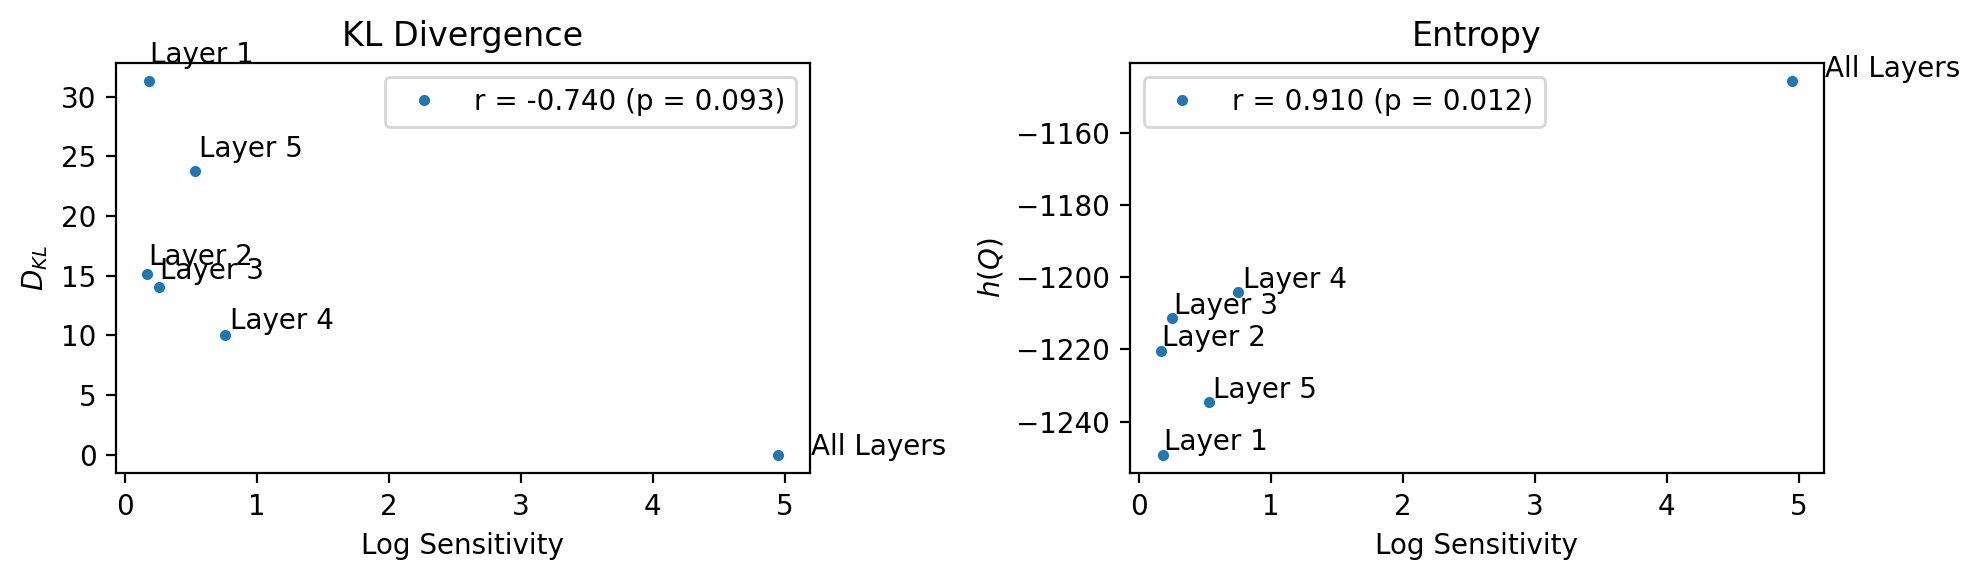

In [132]:
plt.figure(dpi=200, figsize=(10, 3))
plt.subplot(121)
plt.plot(sensitivity, kl_list, '.', label='r = {} (p = {})'.format('%0.3f' % r_kl, '%0.3f' % p_kl))
for i in range(5):
    plt.text(1.05*sensitivity[i],1.05*kl_list[i], 'Layer {}'.format(i+1))
plt.text(1.05*sensitivity[-1], 1.05*kl_list[-1], 'All Layers'.format(i+1))

plt.xlabel('Log Sensitivity')
plt.ylabel(r'$D_{KL}$')
plt.title('KL Divergence')
plt.legend()

plt.subplot(122)
plt.plot(sensitivity, entropy_list, '.', label='r = {} (p = {})'.format('%0.3f' % r_entropy, '%0.3f' % p_entropy))
for i in range(5):
    plt.text(1.05*sensitivity[i],0.999*entropy_list[i], 'Layer {}'.format(i+1))
plt.text(1.05*sensitivity[-1], 0.999*entropy_list[-1], 'All Layers'.format(i+1))
    
plt.xlabel('Log Sensitivity')
plt.ylabel(r'$h(Q)$')
plt.title('Entropy')
plt.legend()

plt.tight_layout()
plt.show()
